# WEATHER FOR RECOVERY



In [34]:
import ee
import datetime
import pandas as pd
import geopandas as gp
import geemap
from shapely.geometry import polygon, Point
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns



Initialize the Earth Engine module.


In [ ]:
ee.Initialize()


Read in the data and check it

In [80]:
# read in data
data = gp.read_file("../data/outputs/on/on_no_insect_history_perimeters.shp")
data.head()

,OGF_ID,r_id,raster_id,Fire_ID,FIRE_DISTU,FIRE_TYPE_,Fire_Year,FIRE_GENER,FIRE_RESPO,FIRE_START,...,GEOMETRY_U,EFFECTIVE_,SYSTEM_DAT,OBJECTID,SHAPEAREA,SHAPELEN,old_f_id,RBR,TIF,geometry
0,46000273,NIP53_2001_1_rbr_.tif,NIP53_2001_1_rbr,NIP53_2001_1,NIP53,IFR,2001,LTG,SUP,2001-06-09,...,None,2002-09-18,2005-04-28,1,0,0,1,rbr,.tif,"MULTIPOLYGON (((-87.20977 52.84332, -87.20982 ..."
1,46000274,NIP39_2001_2_rbr_.tif,NIP39_2001_2_rbr,NIP39_2001_2,NIP39,IFR,2001,LTG,SUP,2001-06-09,...,None,2002-09-18,2005-04-28,2,0,0,2,rbr,.tif,"POLYGON ((-88.43831 52.80370, -88.43843 52.803..."
2,46000278,NIP52_2001_3_rbr_.tif,NIP52_2001_3_rbr,NIP52_2001_3,NIP52,IFR,2001,LTG,MON,2001-06-08,...,None,2002-09-18,2005-04-28,3,0,0,3,rbr,.tif,"POLYGON ((-87.52341 52.50596, -87.52390 52.506..."
3,46000280,NIP40_2001_4_rbr_.tif,NIP40_2001_4_rbr,NIP40_2001_4,NIP40,IFR,2001,LTG,MON,2001-06-09,...,None,2002-09-18,2005-04-28,4,0,0,4,rbr,.tif,"POLYGON ((-87.42676 52.29163, -87.42775 52.292..."
4,46000283,NIP35_2001_5_rbr_.tif,NIP35_2001_5_rbr,NIP35_2001_5,NIP35,IFR,2001,LTG,SUP,2001-06-09,...,None,2002-09-18,2005-04-28,6,0,0,5,rbr,.tif,"POLYGON ((-87.81318 51.55581, -87.81335 51.555..."


In [81]:
# if columns are Fire_Year and defoliated ajust them to match the function
data = data.rename(columns={'Fire_Year': 'Fire_Yr'})

# if there is no index, create index
data['id'] = data.index
data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1257 entries, 0 to 1256
Data columns (total 26 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OGF_ID      1257 non-null   int64   
 1   r_id        1257 non-null   object  
 2   raster_id   1257 non-null   object  
 3   Fire_ID     1257 non-null   object  
 4   FIRE_DISTU  1257 non-null   object  
 5   FIRE_TYPE_  1257 non-null   object  
 6   Fire_Yr     1257 non-null   int64   
 7   FIRE_GENER  1257 non-null   object  
 8   FIRE_RESPO  1257 non-null   object  
 9   FIRE_START  1257 non-null   object  
 10  FIRE_OUT_D  1257 non-null   object  
 11  FIRE_FINAL  1257 non-null   int64   
 12  LOCATION_A  1257 non-null   object  
 13  BUSINESS_E  1094 non-null   object  
 14  GENERAL_CO  689 non-null    object  
 15  GEOMETRY_U  371 non-null    object  
 16  EFFECTIVE_  1257 non-null   object  
 17  SYSTEM_DAT  1257 non-null   object  
 18  OBJECTID    1257 non-null   int64   
 19

Because this data is for recovery only, make sure the no history fires are only up to 2012


In [ ]:
# remove fires burning after 2012
fires_lte_2012 = data[data['Fire_Yr'] <= 2012]

len(fires_lte_2012)


939

In [86]:
# how many fires are burned after 2012

print(len(data[data['Fire_Yr'] > 2012]))


318


get the fire names as a list and check them


In [87]:
fire_names = fires_lte_2012[['Fire_ID']]
print(fire_names)

              Fire_ID
0        NIP53_2001_1
1        NIP39_2001_2
2        NIP52_2001_3
3        NIP40_2001_4
4        NIP35_2001_5
..                ...
972   NIP61_2012_1930
973   SLK47_2012_1932
974   RED62_2012_1936
975   RED70_2012_1937
996  RED124_2011_1958

[939 rows x 1 columns]


## define the length of the growing season for each year from 1986-2022 across canada

Write multiple function that take in a feature collection and returns the minimum and maximum temperature - then searches the results for fires periods when the meteorological growing season was identified as the first day of 7
consecutive days when mean daily Tair was above 5°C (Lund et al., 2010) to the first of 7 consecutive days where mean daily Tair was below 5°C.

In [124]:
def era5_temp_minmax(feature_collection, year):
    """This function takes a feature collection and a year as YYYY and returns:
       a pandas dataframe with a row for date, t, rh,ws, ppt.
       start date and end date are set in the function to April 30 - August 31 of each year.
       This can be adjusted in the function under #Define the date range
       
    """
 # Define the bands to extract
    bands = ['temperature_2m_max', 'temperature_2m_min']
    
    # Function to reduce each image to a dictionary of values
    def reduce_image(image, feature):
        reduced = image.reduceRegion(
            reducer=ee.Reducer.mode(),
            geometry=feature.geometry(),
            scale=1000,
            maxPixels=1e9
        )
        return ee.Feature(None, reduced).set('date', image.date().format('YYYY-MM-dd')).copyProperties(feature, ['Fire_ID',  'id'])
    
    # Function to process each feature in the collection for a given year
    def process_feature(feature, year):
        start_date = f'{year}-04-30'
        end_date = f'{year}-10-31'
        
        # Load the ERA5-Land hourly dataset
        era5_land = ee.ImageCollection('ECMWF/ERA5_LAND/DAILY_AGGR')
        
        # Filter the dataset by date range
        era5_filtered = era5_land.filterDate(start_date, end_date)
        
        # Select the bands
        era5_selected = era5_filtered.select(bands)
        
        # Reduce each image in the filtered collection
        era5_reduced = era5_selected.map(lambda image: reduce_image(image, feature))
        return era5_reduced
    
    # Initialize an empty list to store data for all years
    all_data = []
    
    # Iterate over 10 years starting from the year of interest
    for i in range(11):
        current_year = year + i
        processed_collection = feature_collection.map(lambda feature: process_feature(feature, current_year)).flatten()
        
        # Convert the collection to a list of dictionaries
        data_list = processed_collection.getInfo()['features']
        
        # Extract properties from each feature
        data_dicts = [feature['properties'] for feature in data_list]
        
        # Append data for the current year to the list
        all_data.extend(data_dicts)
    
    # Create a DataFrame
    df = pd.DataFrame(all_data)
    
    df = df[['date', 'temperature_2m_max', 'temperature_2m_min', 'Fire_ID', 'id']]
    
    def kelvin_to_celsius(x):
        return x - 273.15
    
    df['temperature_2m_max'] = df['temperature_2m_max'].apply(kelvin_to_celsius)
    df['temperature_2m_min'] = df['temperature_2m_min'].apply(kelvin_to_celsius)
    
    return df

def find_first_consecutive_days(df, threshold_upper=5, threshold_lower=5,  consecutive_days=5):
    """Find the first occurrence of consecutive days with temperatures below the threshold for each Fire_ID group."""
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values(by='date')
    df['year'] = df['date'].dt.year
    
    def find_consecutive_days_above(group):
        count = 0
        for i in range(len(group)):
            if group.iloc[i]['temperature_2m_max'] > threshold_upper:
                count += 1
                if count == consecutive_days:
                    return group.iloc[i - consecutive_days + 1]['date']
            else:
                count = 0
        return None
    
    # Apply the function to each fire_id and year group
    result = df.groupby(['Fire_ID', 'year']).apply(find_consecutive_days_above).reset_index()
    result.columns = ['Fire_ID', 'year', 'fire_season_start']

    
    # combine results as column back to dataframe
    df_w_start = pd.merge(df, result, on="Fire_ID", how="left")
    
    ### find first below threshold
    df_w_start['date'] = pd.to_datetime(df_w_start['date'])
    df_w_start= df.sort_values(by='date')
    
    df_w_start['month_day'] = df_w_start['date'].dt.strftime('%m-%d')
    
    cutoff_date = '08-31'
    
    df_w_start = df_w_start[df_w_start['month_day'] >= cutoff_date]

    
    def find_consecutive_days_below(group):
        count = 0
        for i in range(len(group)):
            if group.iloc[i]['temperature_2m_min'] < threshold_lower:
                count += 1
                if count == consecutive_days:
                    return group.iloc[i - consecutive_days + 1]['date']
            else:
                count = 0
        return None
    
    result_2 = df_w_start.groupby(['Fire_ID', 'year']).apply(find_consecutive_days_below).reset_index()
    result_2.columns = ['Fire_ID','year', 'fire_season_end']
    


    # merge results
    result_start_end = pd.merge(result, result_2, on="Fire_ID", how="left")

    # make sure year_x == year y
    result_start_end = result_start_end[result_start_end['year_x'] == result_start_end['year_y']]
    result_start_end = result_start_end.drop(columns=['year_y'])
    result_start_end = result_start_end.rename(columns={'year_x': 'year'})
    
    return result_start_end

def row_to_ee_feature(row):
    geom = ee.Geometry.MultiPolygon(row['geometry'].__geo_interface__['coordinates'])
    properties = row.drop('geometry').to_dict()
    return ee.Feature(geom, properties)

In [125]:
# loop through each row in a gdf and return indices

#empty list
all_data_frames = []

#loop
for index, row in data.iterrows():
    year = row['Fire_Yr']
    row = row_to_ee_feature(row)
    feature_collection = ee.FeatureCollection([row])
    df = era5_temp_minmax(feature_collection, year)
    all_data_frames.append(df)

Concatenate all data frames

In [126]:
minmax_df = pd.concat(all_data_frames, ignore_index=True)
minmax_df.head()

,date,temperature_2m_max,temperature_2m_min,Fire_ID,id
0,2001-04-30,21.074030,11.195901,NIP53_2001_1,0
1,2001-05-01,22.432642,5.626138,NIP53_2001_1,0
2,2001-05-02,18.554468,8.724832,NIP53_2001_1,0
3,2001-05-03,7.773965,1.388345,NIP53_2001_1,0
4,2001-05-04,11.553186,-1.516165,NIP53_2001_1,0


save the resulting minmax df 

In [127]:
minmax_df.to_csv("../data/outputs/no_history/on_no_history_minmax_temp.csv", index=False)



Remove fires that burned after 2012


In [128]:
minmax = minmax_df[minmax_df['Fire_ID'].isin(fire_names['Fire_ID'])]
minmax.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1900536 entries, 0 to 2007439
Data columns (total 5 columns):
 #   Column              Dtype  
---  ------              -----  
 0   date                object 
 1   temperature_2m_max  float64
 2   temperature_2m_min  float64
 3   Fire_ID             object 
 4   id                  int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 87.0+ MB


Run the get fire season start end

In [129]:
start_end = find_first_consecutive_days(minmax, threshold_upper=5, threshold_lower=5, consecutive_days=5)

/tmp/ipykernel_1119164/4103112115.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])
/tmp/ipykernel_1119164/4103112115.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = df.groupby(['Fire_ID', 'year']).apply(find_consecutive_days_above).reset_index()
/tmp/ipykernel_1119164/4103112115.py:116: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a 

In [130]:
start_end.head()

,Fire_ID,year,fire_season_start,fire_season_end
0,COC12_2002_53,2002,2002-05-25,2002-09-23
12,COC12_2002_53,2003,2003-05-03,2003-09-23
24,COC12_2002_53,2004,2004-05-15,2004-09-08
36,COC12_2002_53,2005,2005-05-04,2005-10-04
48,COC12_2002_53,2006,2006-04-30,2006-09-17


In [131]:
# check a single id to see if there are multiple years
id_check = start_end[start_end['Fire_ID'] == 'COC12_2002_53']
id_check


,Fire_ID,year,fire_season_start,fire_season_end
0,COC12_2002_53,2002,2002-05-25,2002-09-23
12,COC12_2002_53,2003,2003-05-03,2003-09-23
24,COC12_2002_53,2004,2004-05-15,2004-09-08
36,COC12_2002_53,2005,2005-05-04,2005-10-04
48,COC12_2002_53,2006,2006-04-30,2006-09-17
60,COC12_2002_53,2007,2007-04-30,2007-09-11
72,COC12_2002_53,2008,2008-05-12,2008-09-17
84,COC12_2002_53,2009,2009-05-09,2009-09-28
96,COC12_2002_53,2010,2010-05-09,2010-09-20
108,COC12_2002_53,2011,2011-05-04,2011-10-15


mutate fire season start and end dates to have columns for start_month and start_day and end_month and end_day

In [133]:
#get start month and start day from fire_season_start
start_end['start_month'] = pd.to_datetime(start_end['fire_season_start']).dt.month
start_end['start_day'] = pd.to_datetime(start_end['fire_season_start']).dt.day

# end month and end day from fire_season_end
start_end['end_month'] = pd.to_datetime(start_end['fire_season_end']).dt.month
start_end['end_day'] = pd.to_datetime(start_end['fire_season_end']).dt.day

start_end.head()


,Fire_ID,year,fire_season_start,fire_season_end,start_month,start_day,end_month,end_day
0,COC12_2002_53,2002,2002-05-25,2002-09-23,5,25,9.0,23.0
12,COC12_2002_53,2003,2003-05-03,2003-09-23,5,3,9.0,23.0
24,COC12_2002_53,2004,2004-05-15,2004-09-08,5,15,9.0,8.0
36,COC12_2002_53,2005,2005-05-04,2005-10-04,5,4,10.0,4.0
48,COC12_2002_53,2006,2006-04-30,2006-09-17,4,30,9.0,17.0


In [134]:
start_end.to_csv("../data/outputs/no_history/on_no_history_fire_season_start_end_date.csv", index=False)

## Get data for the growing season of boreal


In [135]:
def extract_era5_clim(feature_collection, year, climate_data):
    """
    This function takes a feature collection, a year as YYYY, and a climate data DataFrame,
    and returns a pandas DataFrame with a row for date, t, rh, ws, ppt.
    Start date and end date are set in the function to April 30 - August 31 of each year.
    This can be adjusted in the function under #Define the date range.
    """
    # Define the bands to extract
    bands = ['temperature_2m_max', 'total_precipitation_sum']

    # Function to reduce each image to a dictionary of values
    def reduce_image(image, feature):
        reduced = image.reduceRegion(
            reducer=ee.Reducer.mode(),
            geometry=feature.geometry(),
            scale=1000,
            maxPixels=1e9
        )
        return ee.Feature(None, reduced).set('date', image.date().format('YYYY-MM-dd')).copyProperties(feature, ['Fire_ID', 'id'])
    
    # Function to process each feature in the collection for a given year
    def process_feature(feature, year):
        fire_id = feature.get('Fire_ID')
        
        # Get the corresponding row in climate_data
        climate_row = climate_data[(climate_data['Fire_ID'] == fire_id) & (climate_data['year'] == year)]
        if not climate_row.empty:
            start_month = int(climate_row['start_month'].values[0])
            start_day = int(climate_row['start_day'].values[0])
            end_month = int(climate_row['end_month'].values[0])
            end_day = int(climate_row['end_day'].values[0])

            # Define the start and end dates
            start_date = f'{year}-{start_month:02d}-{start_day:02d}'
            end_date = f'{year}-{end_month:02d}-{end_day:02d}'
        else:
            # Default start and end dates if no matching row is found
            start_date = f'{year}-04-30'
            end_date = f'{year}-10-31'
        
        # Load the ERA5-Land hourly dataset
        era5_land = ee.ImageCollection('ECMWF/ERA5_LAND/DAILY_AGGR')
        
        # Filter the dataset by date range
        era5_filtered = era5_land.filterDate(start_date, end_date)
        
        # Select the bands
        era5_selected = era5_filtered.select(bands)
        
        # Reduce each image in the filtered collection
        era5_reduced = era5_selected.map(lambda image: reduce_image(image, feature))
        return era5_reduced
    
    # Initialize an empty list to store data for all years
    all_data = []

    # Iterate over 10 years starting from the year of interest
    for i in range(11):
        current_year = year + i
        processed_collection = feature_collection.map(lambda feature: process_feature(feature, current_year)).flatten()
        
        # Convert the collection to a list of dictionaries
        data_list = processed_collection.getInfo()['features']
        
        # Extract properties from each feature
        data_dicts = [feature['properties'] for feature in data_list]
        
        # Append data for the current year to the list
        all_data.extend(data_dicts)
    
    # Create a DataFrame
    df = pd.DataFrame(all_data)
    
    df = df[['date', 'temperature_2m_max', 'total_precipitation_sum', 'Fire_ID', 'id']]

    def kelvin_to_celsius(x):
        return x - 273.15
    
    df['temperature_2m_max'] = df['temperature_2m_max'].apply(kelvin_to_celsius)
    
    return df


Loop through each of the rows in a GeoDataFrame, return each row as feature, run era5 extract function and append to a list





In [ ]:
def row_to_ee_feature(row):
    geom = ee.Geometry.MultiPolygon(row['geometry'].__geo_interface__['coordinates'])
    properties = row.drop('geometry').to_dict()
    return ee.Feature(geom, properties)

Concatenate all dfs in list



In [ ]:
# loop through each row in a gdf and return indices

#empty list
all_data_frames = []

#loop
for index, row in fires_lte_2012.iterrows():
    year = row['Fire_Yr']
    row = row_to_ee_feature(row)
    feature_collection = ee.FeatureCollection([row])
    df = extract_era5_clim(feature_collection, year, start_end)
    all_data_frames.append(df)

# ONTARIO WEATHER STATION DATA


data only goes to 2021, how many fires with defoliation history burned in 2012?

In [89]:
history = pd.read_csv("../data/outputs/on/on_defoliation_history.csv")

history.columns


Index(['Fire_ID', 'history', 'rbr', 'rbr_w_offset', 'Fire_Year',
       'host_species', 'total_pixels', 'host_percentage', 'Average Recovery',
       'Time_Since_Defoliation', 'Cumulative_Years', 'Max_Overlap_Area',
       'Max_Overlap_Percent', 'fire_area'],
      dtype='object')

In [95]:
print(len(history[history['Fire_Year'] == 2012]))


72


In [18]:
on_station_data = pd.read_csv("/home/goldma34//fire_insect_co-occurence/data/outputs/on/ontario-complete-wx-data-90-21.csv")

on_station_data.head()

/tmp/ipykernel_1119164/4134747018.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  on_station_data = pd.read_csv("/home/goldma34//fire_insect_co-occurence/data/outputs/on/ontario-complete-wx-data-90-21.csv")


,Unnamed: 0,id,long,lat,yr,mon,day,temp,rh,ws,prec,date
0,1,1AL,-79.8746,44.1506,2000,4,18,6.0,81,15.0,0.0,2000-04-18
1,2,1AL,-79.8746,44.1506,2000,4,19,9.0,87,7.0,0.0,2000-04-19
2,3,1AL,-79.8746,44.1506,2000,4,23,12.0,62,13.0,0.0,2000-04-23
3,4,1AL,-79.8746,44.1506,2000,4,24,10.0,43,11.0,0.0,2000-04-24
4,5,1AL,-79.8746,44.1506,2000,4,25,10.0,27,8.0,0.0,2000-04-25


Explore station id data frame

In [20]:
on_station_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 819182 entries, 0 to 819181
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  819182 non-null  int64  
 1   id          819182 non-null  object 
 2   long        819182 non-null  float64
 3   lat         819182 non-null  float64
 4   yr          819182 non-null  int64  
 5   mon         819182 non-null  int64  
 6   day         819182 non-null  int64  
 7   temp        819182 non-null  float64
 8   rh          819182 non-null  int64  
 9   ws          819182 non-null  float64
 10  prec        819182 non-null  float64
 11  date        819182 non-null  object 
dtypes: float64(5), int64(5), object(2)
memory usage: 75.0+ MB


In [23]:
on_station_data['id'].unique()


array(['1AL', '1AU', '1AZ', '1BA', '1BI', '1BK', '1BU', '1CA', '1CS',
       '1DM', '1DS', '1FI', '1FL', '1FS', '1GN', '1IR', '1KS', '1LA',
       '1LD', '1LI', '1LV', '1MA', '1MO', '1MT', '1OJ', '1PA', '1PB',
       '1PE', '1PH', '1PI', '1PL', '1PT', '1RN', '1SC', '1SU', '1SW',
       '1TB', '1TP', '1TS', '1WI', '1bg', '2DC', '2PI', '3CM', '4AL',
       '4AN', '4AR', '4AT', '4AU', '4BA', '4BD', '4BJ', '4BL', '4BN',
       '4BR', '4BU', '4BV', '4BW', '4CA', '4CB', '4CD', '4CH', '4CL',
       '4CO', '4CR', '4CT', '4DC', '4DE', '4DL', '4DO', '4DS', '4DU',
       '4EG', '4EN', '4FD', '4FH', '4FO', '4FT', '4FW', '4FX', '4GA',
       '4GO', '4GR', '4HB', '4HE', '4HO', '4HW', '4IL', '4JE', '4KA',
       '4KE', '4KH', '4KI', '4KL', '4KN', '4KS', '4LA', '4LL', '4LN',
       '4LO', '4LP', '4MA', '4MD', '4MI', '4MR', '4MS', '4MT', '4NA',
       '4NC', '4NG', '4NI', '4NO', '4OB', '4OG', '4OP', '4OW', '4PE',
       '4PI', '4PL', '4PN', '4PO', '4PT', '4PU', '4QR', '4RA', '4RD',
       '4RE', '4RM',

plot stations

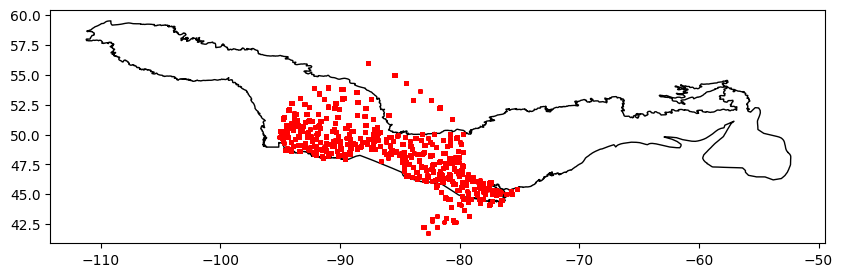

In [35]:

# Load your data
# Load Ontario shapefile
on_boreal = gp.read_file('../data/maps/boreal_shield.shp')

# Create a GeoDataFrame from your data
geometry = [Point(xy) for xy in zip(on_station_data['long'], on_station_data['lat'])]
geo_df = gp.GeoDataFrame(on_station_data, geometry=geometry)

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))
on_boreal.plot(ax=ax, color='white', edgecolor='black')
geo_df.plot(ax=ax, marker='o', color='red', markersize=5)
plt.show()

Remove stations that are not within the bounds of boreal shield

In [43]:
# Set the CRS for geo_df if not already set
if geo_df.crs is None:
	geo_df.set_crs(epsg=4326, inplace=True)  # Assuming the original CRS is WGS84

# Transform the CRS to match on_boreal
shield_stations = geo_df.drop_duplicates(subset=['id']).to_crs(on_boreal.crs)
shield_stations.head()


,Unnamed: 0,id,long,lat,yr,mon,day,temp,rh,ws,prec,date,geometry
0,1,1AL,-79.8746,44.1506,2000,4,18,6.0,81,15.0,0.0,2000-04-18,POINT (-79.87460 44.15060)
19,20,1AU,-78.5410,46.1191,1994,5,6,12.1,86,8.0,3.6,1994-05-06,POINT (-78.54100 46.11910)
40,41,1AZ,-80.1623,46.7365,1994,5,5,14.2,44,0.0,0.0,1994-05-05,POINT (-80.16230 46.73650)
61,62,1BA,-91.3049,48.9944,1996,8,11,24.3,72,14.0,0.0,1996-08-11,POINT (-91.30490 48.99440)
94,95,1BI,-85.7487,49.8276,1997,7,29,26.0,42,14.0,0.0,1997-07-29,POINT (-85.74870 49.82760)


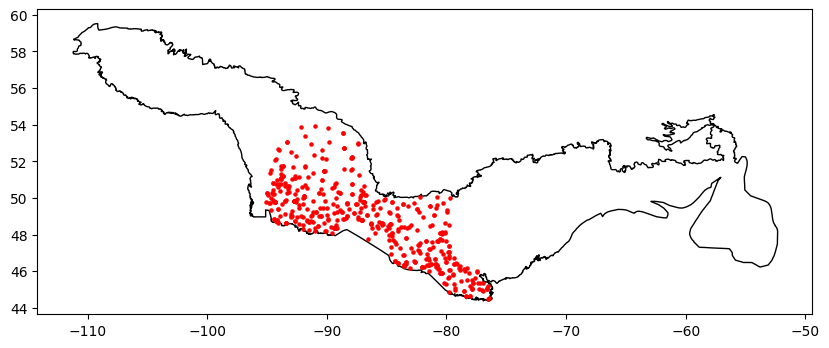

In [ ]:
# get stations that intersect boreal shield
shield_stations = gp.overlay(shield_stations, on_boreal, how='intersection')

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))
on_boreal.plot(ax=ax, color='white', edgecolor='black')
shield_stations.plot(ax=ax, marker='o', color='red', markersize=5)
plt.show()

get the ids and filter original set 

In [54]:
shield_stations_ids = shield_stations['id'].unique()
print("shield only:", len(shield_stations_ids), "full Ontario:", len(on_station_data['id'].unique()))


shield only: 484 full Ontario: 547


In [55]:
#filter original
shield_data = on_station_data[on_station_data['id'].isin(shield_stations_ids)]
len(shield_data['id'].unique())

484

Look at the duration in terms of years for each station and plot as a graph
- first extract year from ymd column if it doesnt already exist
- for each station ID get the minmax year
- then plot the station id on the y, year on the x and had a connection line/dot plot with years on x


In [57]:
shield_data.columns


Index(['Unnamed: 0', 'id', 'long', 'lat', 'yr', 'mon', 'day', 'temp', 'rh',
       'ws', 'prec', 'date'],
      dtype='object')

In [67]:
# minmax yr per station id
# Group by 'station_id' and get the max and min values in the 'yr' column
shield_minmax_data = shield_data.groupby('id')['yr'].agg(['min', 'max']).reset_index()

# Rename columns for clarity
shield_minmax_data.columns = ['station_id', 'min_yr', 'max_yr']

# Display the new dataframe
print(shield_minmax_data.head())

  station_id  min_yr  max_yr
0    6014351    2019    2019
1    6016525    2004    2019
2    6016527    1990    2012
3    6016529    2012    2012
4    6016970    2012    2012


In [66]:
print("min yr limits:", shield_minmax_data['min_yr'].agg(['min', 'max']),
      "max yr limits:", shield_minmax_data['max_yr'].agg(['min', 'max']))


min yr limits: min    1990
max    2021
Name: min_yr, dtype: int64 max yr limits: min    1990
max    2021
Name: max_yr, dtype: int64


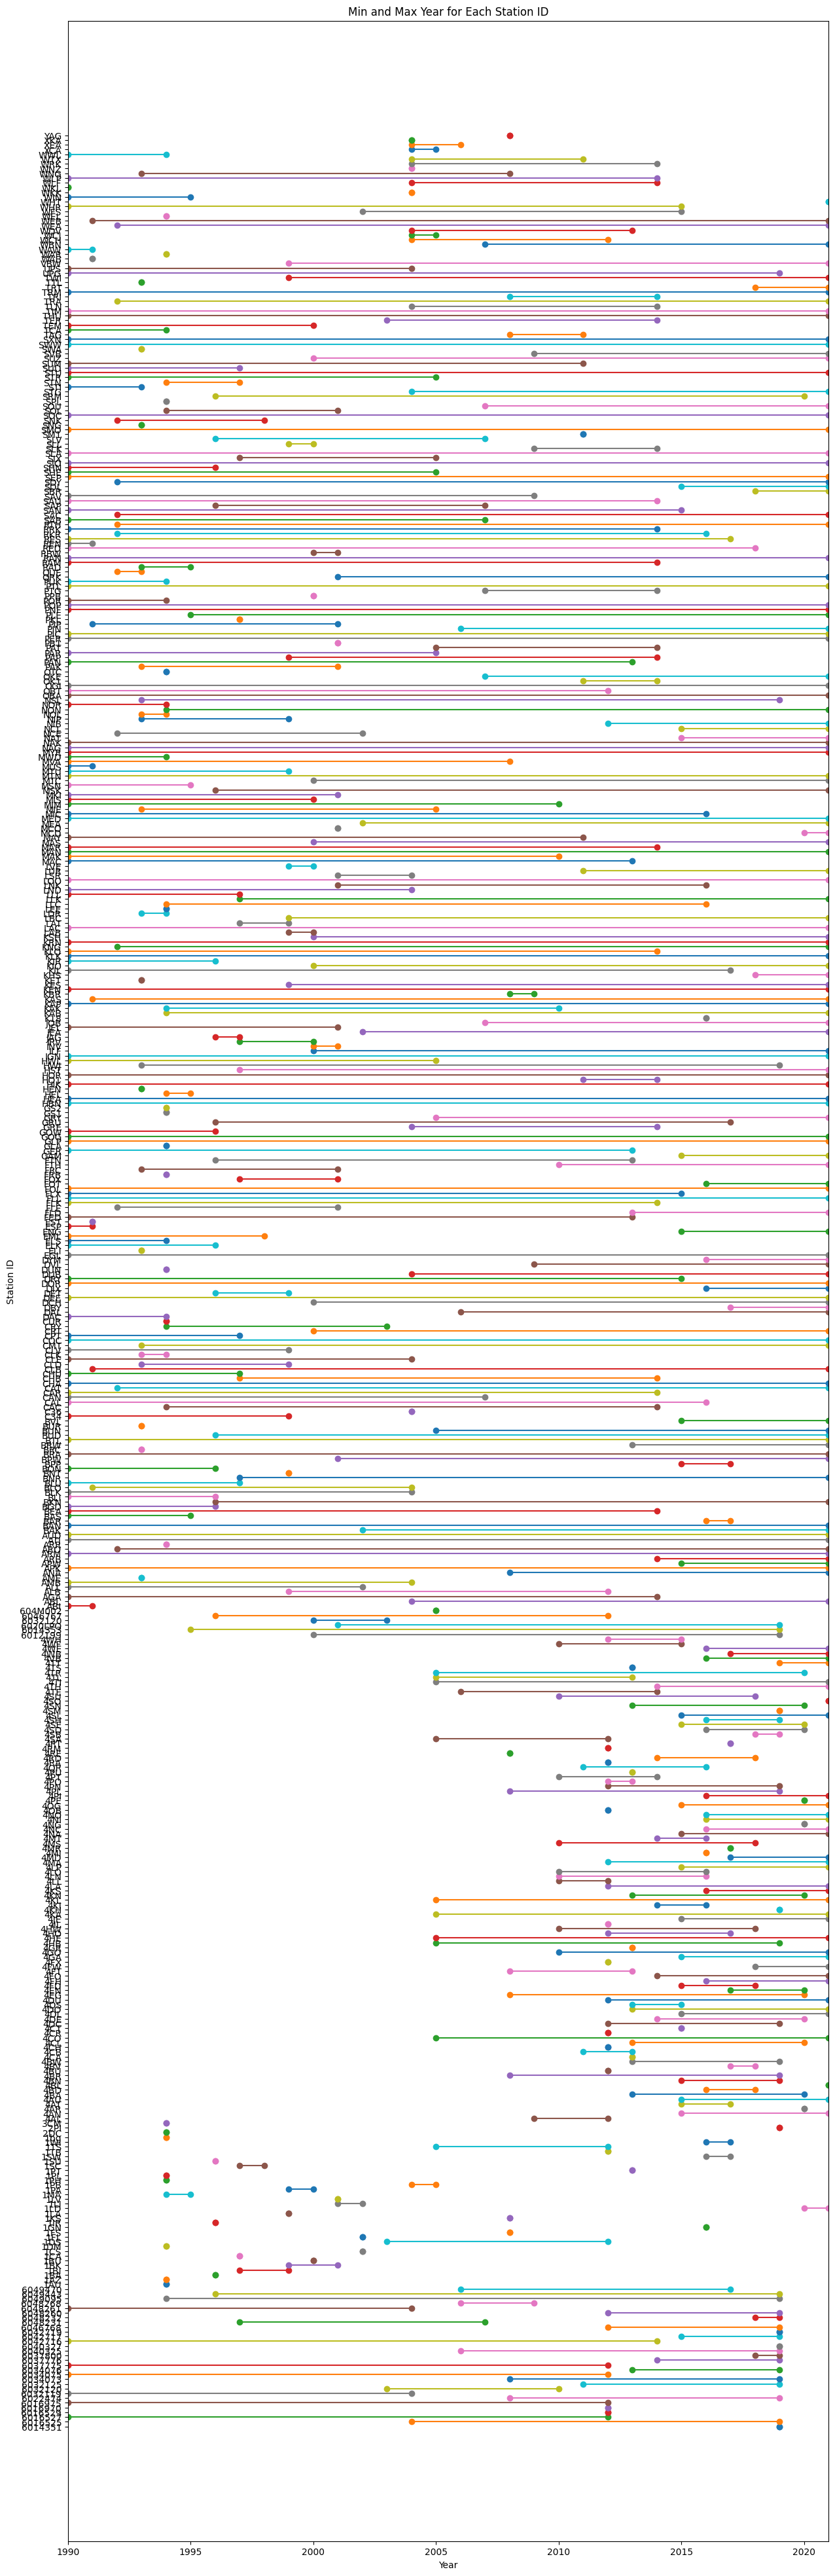

In [73]:
# Plotting
fig, ax = plt.subplots(figsize=(15, 50))  # Adjust the figure size to fit all values

# Plot each station_id with a line connecting min_yr and max_yr
for i, row in enumerate(shield_minmax_data.itertuples(), 1):
    ax.plot([row.min_yr, row.max_yr], [i, i], marker='o')

# Set labels and title
ax.set_xlabel('Year')
ax.set_ylabel('Station ID')
ax.set_title('Min and Max Year for Each Station ID')
ax.set_xlim(1990, 2021)
ax.set_yticks(range(1, len(shield_minmax_data) + 1))
ax.set_yticklabels(shield_minmax_data['station_id'])

# Show plot
plt.show()